In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
dirO="./out/out_zoo_RF"
outputdir=dirO

In [3]:
outputF=True

In [4]:
toCompute=True

In [5]:
n_pred=5

# Import dataset

In [6]:
dataset_name="zoo"

In [7]:
df = pd.read_csv(f"./datasets/zoo.tab", sep="\t", dtype=str)
meta_col="name"
df.rename(columns={"type":"class"}, inplace=True )
df.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class,name
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,mammal,aardvark
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,mammal,antelope
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,fish,bass
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,mammal,bear
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,mammal,boar


In [8]:
from ProcessedDataset import ProcessedDataset

In [9]:
all_data=True
pc = ProcessedDataset(df, meta_col=meta_col)

from sklearn.ensemble import RandomForestClassifier
clf_init = RandomForestClassifier(random_state=42)
pc.processDataset(clf_init, all_data=True)

In [10]:
predicted=np.argmax(pc.predict_fn(pc.test.values), axis=1)
mispredicted=[i for i,p in enumerate(predicted) if p!=pc.labels_test[i]]
correct_prediction=[i for i,p in enumerate(predicted) if p==pc.labels_test[i]]

In [11]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", round(accuracy_score(pc.labels_test, predicted),4))

Accuracy:  1.0


# LIME

In [12]:
import lime
import lime.lime_tabular
np.random.seed(1)

In [13]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(pc.train.values ,feature_names = pc.feature_names,class_names=pc.class_names,
                                                   categorical_features=pc.categorical_features_pos, 
                                                   categorical_names=pc.categorical_names_LE, kernel_width=3)

# SHAP

In [14]:
if toCompute:
    import shap

    shap_explainer = shap.TreeExplainer(pc.clf)
    shap_values = shap_explainer.shap_values(pc.OH_X_test_cols.iloc[0:])

# Anchor

In [15]:
from anchor import utils
from anchor import anchor_tabular

In [16]:
anchor_explainer = anchor_tabular.AnchorTabularExplainer(
    pc.class_names,
    pc.feature_names,
    pc.train.values,
    pc.categorical_names_LE)

# LACE

In [17]:
from src.LACE_explainer import LACE_explainer

lace_explainer = LACE_explainer(pc.d_train,pc.predict_fn, dataset_name="COMPAS")

# Comparison

LIME
SHAP
Id 1
Anchor: milk = 1 AND eggs = 0
Predicted class:  5
Precision: 1.00
Coverage: 0.41
{'Rule_1': (['feathers=0', 'milk=1', 'backbone=1', 'breathes=1', 'venomous=0'], '-->', 'mammal')}
['feathers=0', 'milk=1', 'backbone=1', 'breathes=1', 'venomous=0'] --> mammal 42 support: 0.46153846153846156 confidence: 100.0 [2, 4, 9, 10, 11]
### Changes ({}, {})


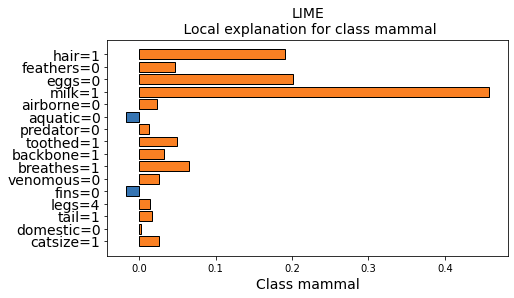

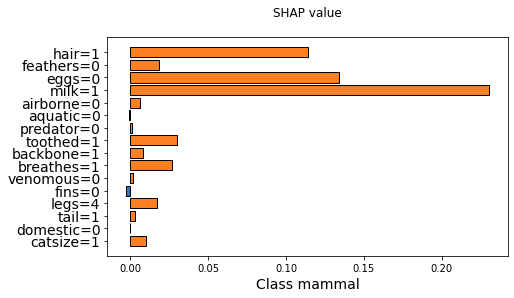

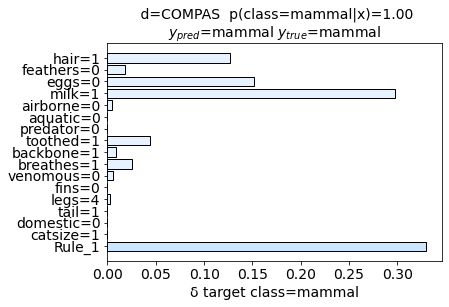

In [18]:
for id_i in [1]:
    from utils_RW import plot_lime_explanation
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    print("LIME")
    exp = lime_explainer.explain_instance(pc.test.iloc[id_i].values, pc.predict_fn, num_features=len(pc.feature_names), labels=[predicted_class])
    fig_lime = plot_lime_explanation(exp, label=predicted_class, pred=pc.class_names[np.argmax(pc.predict_fn(pc.test.iloc[id_i:id_i+1].values))], true_label=pc.class_names[pc.labels_test[id_i]])
    fig_lime.set_size_inches(7.25, 4.25)
    fig_lime.tight_layout()
    
    
    from utils_RW import sumCategories, plotShapValues, convertInstance
    print("SHAP")
    instance=pc.OH_X_test_cols.iloc[id_i]
    shap_values = shap_explainer.shap_values(instance)
    matching_instance=convertInstance(instance, pc.categorical_features, pc.continuos_features)

    sum_shap_for_categories=sumCategories(shap_values[predicted_class], pc.oh_columns, pc.categorical_features, matching_instance)
    fig_shap=plotShapValues(list(sum_shap_for_categories.values()), list(sum_shap_for_categories.keys()), target_class=pc.class_names[predicted_class], \
                   pred=pc.class_names[pc.clf.predict([instance])[0]], true=pc.class_names[pc.labels_test[id_i]])
    fig_shap.set_size_inches(7.25, 4.25)
    fig_shap.tight_layout()
 
    from utils_RW import printAnchor, dictAnchor
    exp = anchor_explainer.explain_instance(pc.test.iloc[id_i].values, pc.predict_fn_class, threshold=0.95)
    printAnchor(id_i, exp)
    dictAnchor(id_i, exp)
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        verbose=False)
    fig_lace=explanation_fm.plotExplanation(showRuleKey=False, retFig=True)
    explanation_fm.local_rules.printLocalRules()
    changes=explanation_fm.estimateSingleAttributeChangePrediction()
    if changes:
        print("### Changes", changes)

LIME
SHAP
Id 97
Anchor: legs = 6 AND backbone = 0 AND airborne = 1
Predicted class:  3
Precision: 1.00
Coverage: 0.06
{'Rule_1': (['feathers=0', 'eggs=1', 'milk=0', 'aquatic=0', 'toothed=0', 'backbone=0', 'breathes=1', 'fins=0', 'legs=6', 'tail=0', 'catsize=0'], '-->', 'insect')}
['feathers=0', 'eggs=1', 'milk=0', 'aquatic=0', 'toothed=0', 'backbone=0', 'breathes=1', 'fins=0', 'legs=6', 'tail=0', 'catsize=0'] --> insect 9 support: 0.0989010989010989 confidence: 100.0 [2, 3, 4, 6, 8, 9, 10, 12, 13, 14, 16]
### Changes ({}, {})


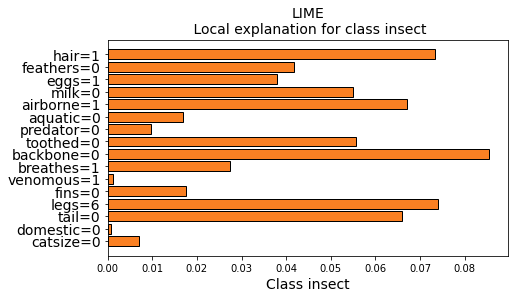

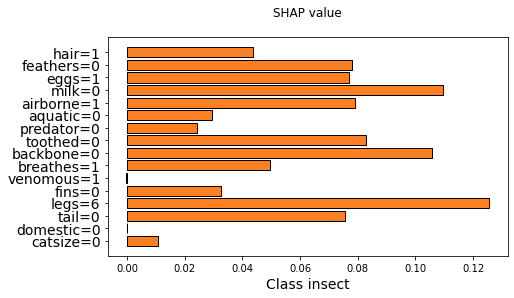

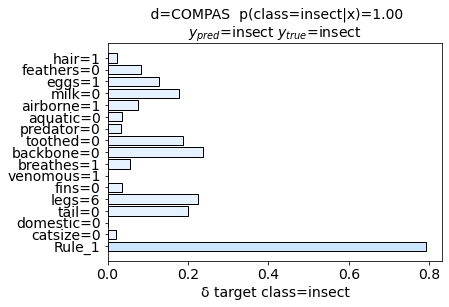

In [21]:
for id_i in [97]:
    from utils_RW import plot_lime_explanation
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    print("LIME")
    exp = lime_explainer.explain_instance(pc.test.iloc[id_i].values, pc.predict_fn, num_features=len(pc.feature_names), labels=[predicted_class])
    fig_lime = plot_lime_explanation(exp, label=predicted_class, pred=pc.class_names[np.argmax(pc.predict_fn(pc.test.iloc[id_i:id_i+1].values))], true_label=pc.class_names[pc.labels_test[id_i]])
    fig_lime.set_size_inches(7.25, 4.25)
    fig_lime.tight_layout()
    
    
    from utils_RW import sumCategories, plotShapValues, convertInstance
    print("SHAP")
    instance=pc.OH_X_test_cols.iloc[id_i]
    shap_values = shap_explainer.shap_values(instance)
    matching_instance=convertInstance(instance, pc.categorical_features, pc.continuos_features)

    sum_shap_for_categories=sumCategories(shap_values[predicted_class], pc.oh_columns, pc.categorical_features, matching_instance)
    fig_shap=plotShapValues(list(sum_shap_for_categories.values()), list(sum_shap_for_categories.keys()), target_class=pc.class_names[predicted_class], \
                   pred=pc.class_names[pc.clf.predict([instance])[0]], true=pc.class_names[pc.labels_test[id_i]])
    fig_shap.set_size_inches(7.25, 4.25)
    fig_shap.tight_layout()
 
    from utils_RW import printAnchor, dictAnchor
    exp = anchor_explainer.explain_instance(pc.test.iloc[id_i].values, pc.predict_fn_class, threshold=0.95)
    printAnchor(id_i, exp)
    dictAnchor(id_i, exp)
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        verbose=False)
    fig_lace=explanation_fm.plotExplanation(showRuleKey=False, retFig=True)
    explanation_fm.local_rules.printLocalRules()
    changes=explanation_fm.estimateSingleAttributeChangePrediction()
    if changes:
        print("### Changes", changes)

LIME
SHAP
Id 8
Anchor: fins = 1 AND breathes = 0 AND legs = 0 AND tail = 1 AND catsize = 0
Predicted class:  2
Precision: 1.00
Coverage: 0.09
{'Rule_1': (['hair=0', 'feathers=0', 'eggs=1', 'milk=0', 'airborne=0', 'aquatic=1', 'toothed=1', 'backbone=1', 'breathes=0', 'fins=1', 'legs=0', 'tail=1'], '-->', 'fish')}
['hair=0', 'feathers=0', 'eggs=1', 'milk=0', 'airborne=0', 'aquatic=1', 'toothed=1', 'backbone=1', 'breathes=0', 'fins=1', 'legs=0', 'tail=1'] --> fish 14 support: 0.34146341463414637 confidence: 100.0 [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14]
### Changes ({}, {'fins=0': 'reptile'})


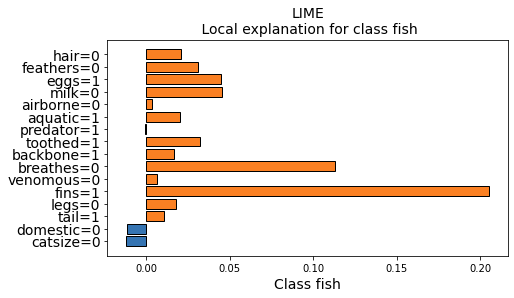

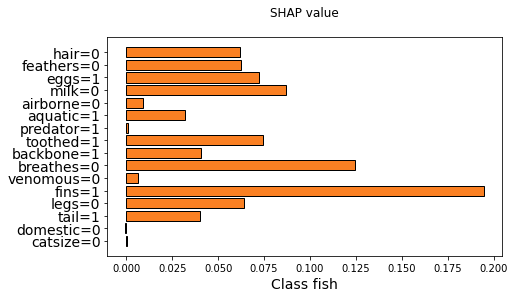

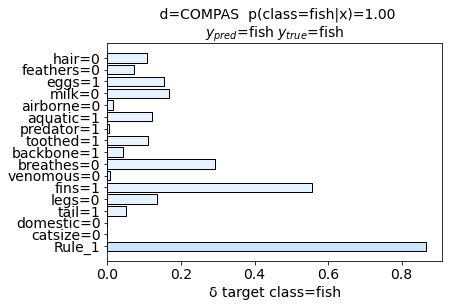

In [25]:
for id_i in [8]:
    from utils_RW import plot_lime_explanation
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    print("LIME")
    exp = lime_explainer.explain_instance(pc.test.iloc[id_i].values, pc.predict_fn, num_features=len(pc.feature_names), labels=[predicted_class])
    fig_lime = plot_lime_explanation(exp, label=predicted_class, pred=pc.class_names[np.argmax(pc.predict_fn(pc.test.iloc[id_i:id_i+1].values))], true_label=pc.class_names[pc.labels_test[id_i]])
    fig_lime.set_size_inches(7.25, 4.25)
    fig_lime.tight_layout()
    
    
    from utils_RW import sumCategories, plotShapValues, convertInstance
    print("SHAP")
    instance=pc.OH_X_test_cols.iloc[id_i]
    shap_values = shap_explainer.shap_values(instance)
    matching_instance=convertInstance(instance, pc.categorical_features, pc.continuos_features)

    sum_shap_for_categories=sumCategories(shap_values[predicted_class], pc.oh_columns, pc.categorical_features, matching_instance)
    fig_shap=plotShapValues(list(sum_shap_for_categories.values()), list(sum_shap_for_categories.keys()), target_class=pc.class_names[predicted_class], \
                   pred=pc.class_names[pc.clf.predict([instance])[0]], true=pc.class_names[pc.labels_test[id_i]])
    fig_shap.set_size_inches(7.25, 4.25)
    fig_shap.tight_layout()
 
    from utils_RW import printAnchor, dictAnchor
    exp = anchor_explainer.explain_instance(pc.test.iloc[id_i].values, pc.predict_fn_class, threshold=0.95)
    printAnchor(id_i, exp)
    dictAnchor(id_i, exp)
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        verbose=False)
    fig_lace=explanation_fm.plotExplanation(showRuleKey=False, retFig=True)
    explanation_fm.local_rules.printLocalRules()
    changes=explanation_fm.estimateSingleAttributeChangePrediction()
    if changes:
        print("### Changes", changes)

## Conterfactual 

In [26]:
explanation_fm.estimateSingleAttributeChangePrediction(verbose=True)

({}, {'fins=0': 'reptile'})

# What-if analysis

Users can select the attributes of interest, tweak the values and observe how the prediction and explanation change

SelectMultiple(description='Feature', options=('hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'pre…

Button(description='Select attributes', style=ButtonStyle())

SelectionSlider(continuous_update=False, description='feathers', options=('0', '1'), value='0')

{'Rule_1': (['hair=0', 'feathers=0', 'eggs=1', 'milk=0', 'airborne=0', 'aquatic=1', 'toothed=1', 'backbone=1', 'breathes=0', 'fins=1', 'legs=0', 'tail=1'], '-->', 'fish')}
['hair=0', 'feathers=0', 'eggs=1', 'milk=0', 'airborne=0', 'aquatic=1', 'toothed=1', 'backbone=1', 'breathes=0', 'fins=1', 'legs=0', 'tail=1'] --> fish 14 support: 0.34146341463414637 confidence: 100.0 [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14]


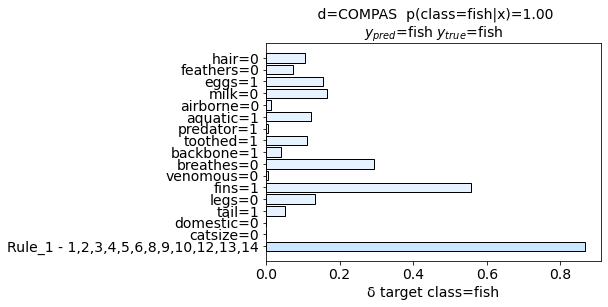

In [27]:
instance=explanation_fm.encoded_instance
predicted_class=pc.predict_fn_class(instance.values.reshape(1,-1))[0]
target_class_decoded=pc.class_names[predicted_class]
explanation_fm.interactiveAttributeLevelInspectionExp(target_class_decoded)